### adjusted 
    * removed dprecations for menpo.0.8.1:
        * .visualize_pointclouds
        * .lms as per deprecation warning MenpoDeprecationWarning: menpo.landmark.LandmarkGroup is now deprecated and has been moved to menpo.shape.LandmarkGroup.MenpoDeprecationWarning)

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

In [2]:
import menpo
import tensorflow as tf
import menpo.io as mio
import numpy as np
import scipy
import matplotlib.pyplot as plt
from pathlib import Path

from tensorflow.python.platform import tf_logging as logging
from menpo.image import Image
from menpo.shape import PointCloud

import utils, networks, data_provider
import numpy as np
import menpo.io as mio
import scipy.io as sio
from io import BytesIO
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xml.etree.ElementTree as ET
import json
import glob
import cv2
import scipy
import utils
import os
import os.path
from menpo.image import Image
from menpo.visualize import print_dynamic, print_progress
from scipy.spatial.distance import pdist
from pathlib import Path

from menpo.shape import PointCloud, PointUndirectedGraph
from menpo.transform import Translation, Scale
from menpofit.transform import DifferentiableAlignmentSimilarity

from menpowidgets import visualize_images#, visualize_pointclouds
from PIL import Image as PImage
import numpy as np

import matplotlib.pyplot as plt
import pylab
import tensorflow as tf
import detect_face
from flags import FLAGS

np.set_printoptions(3)
slim = tf.contrib.slim
%matplotlib inline

In [3]:
def crop_image_bounding_box(img, bbox, res, base=256., order=1):

    center = bbox.centre()
    bmin, bmax = bbox.bounds()
    scale = np.linalg.norm(bmax - bmin) / base

    return crop_image(img, center, scale, res, base, order=order)

def crop_image(img, center, scale, res, base=256., order=1):
    h = scale

    t = Translation(
        [
            res[0] * (-center[0] / h + .5),
            res[1] * (-center[1] / h + .5)
        ]).compose_after(Scale((res[0] / h, res[1] / h))).pseudoinverse()

    # Upper left point
    ul = np.floor(t.apply([0, 0]))
    # Bottom right point
    br = np.ceil(t.apply(res).astype(np.int))

    # crop and rescale
    cimg, trans = img.warp_to_shape(
        br - ul, Translation(-(br - ul) / 2 + (br + ul) / 2), return_transform=True)

    c_scale = np.min(cimg.shape) / np.mean(res)
    new_img = cimg.rescale(1 / c_scale, order=order).resize(res, order=order)

    trans = trans.compose_after(Scale([c_scale, c_scale]))

    return new_img, trans

def tf_heatmap_to_lms(heatmap):
    hs = tf.argmax(tf.reduce_max(heatmap, 2), 1)
    ws = tf.argmax(tf.reduce_max(heatmap, 1), 1)
    lms = tf.transpose(tf.to_float(tf.stack([hs, ws])), perm=[1, 2, 0])
    return lms

In [4]:
minsize = 40 # minimum size of face
threshold = [ 0.6, 0.7, 0.7 ]  # three steps's threshold
factor = 0.709 # scale factor

with tf.Graph().as_default():
    sess = tf.Session()
    with sess.as_default():
        pnet, rnet, onet = detect_face.create_detector(sess, './detection')

./detection/cas3.npy True


In [5]:
model_path = './ckpt/2D86/model.ckpt-217348'
template = mio.import_pickle('./image/template.pkl.gz')
n_landmarks = 86
FLAGS.n_landmarks = 86
with tf.Graph().as_default() as g:
    images_input = tf.placeholder(tf.float32, shape=(None, None, None, 3), name='input_images')
    net_model = networks.DNFaceMultiView('')
    with tf.variable_scope('net'):
        lms_heatmap_prediction,states = net_model._build_network(images_input, datas=None, is_training=False, n_channels=n_landmarks)
        pts_predictions = tf_heatmap_to_lms(lms_heatmap_prediction)
        variables_to_restore = slim.get_variables_to_restore()
        saver = tf.train.Saver(variables_to_restore)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config,graph=g)

saver.restore(sess, model_path)

/home/z/miniconda3/envs/abg10/lib/python3.6/site-packages/menpo/shape/labelled.py:212: MenpoDeprecationWarning: menpo.landmark.LandmarkGroup is now deprecated and has been moved to menpo.shape.LandmarkGroup.
  MenpoDeprecationWarning)


INFO:tensorflow:Restoring parameters from ./ckpt/2D86/model.ckpt-217348


# left profile

In [6]:
image_path = './image/ID01_004.jpg'
image = mio.import_image(image_path)  
image_path = image.path
image_ID_name = image_path.stem
bounding_boxes, points = detect_face.detect_face(image.pixels_with_channels_at_back() * 255, minsize, pnet, rnet, onet, threshold, factor)
print('Box Number: %s' % bounding_boxes.shape[0])
batch_pixels = []
batch_trans = []
batch_image_names = []

for box_index in np.arange(bounding_boxes.shape[0]):
    bbox = PointCloud(bounding_boxes[box_index,[1,0,3,2]].reshape([2,2])).bounding_box()
    crop_img, crop_trans = crop_image_bounding_box(image, bbox, [256., 256.], base=256./256., order=1)
    input_pixels = crop_img.pixels_with_channels_at_back()
    batch_pixels.append(input_pixels)
    batch_trans.append(crop_trans)
    batch_image_names.append('./image/' + image_ID_name + '__' + str(box_index) + '.pts')
    
pts_pred = sess.run(
    pts_predictions,
    feed_dict={images_input: np.stack(batch_pixels, axis=0)})

for inner_batch_index in np.arange(bounding_boxes.shape[0]):
    orig_pts = batch_trans[inner_batch_index].apply(PointCloud(pts_pred[inner_batch_index]))
    template.landmarks['SAVEPTS'] = orig_pts
    mio.export_landmark_file(template.landmarks['SAVEPTS'], batch_image_names[inner_batch_index],extension='pts', overwrite=True)

Box Number: 1


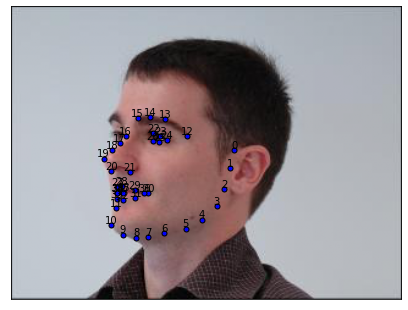

In [7]:
mask_index = np.array([17, 16, 15, 14, 13, 78, 79, 80, 81, 82, 83, 84, 27, 85, 86, 23,
                           28, 29, 30, 31, 34, 36, 44, 45, 46, 47, 48, 52, 53, 54, 55, 56, 57, 58, 63, 64, 65, 66, 67])-1

image.view()
image.landmarks['PTS']= mio.import_landmark_file('./image/ID01_004__0.pts')

orig_pts = PointCloud((image.landmarks['PTS'].points[mask_index,0:2]))

orig_pts.view(marker_face_colour='b', render_numbering=True)

# right profile

In [8]:
image_path = './image/ID01_017.jpg'
image = mio.import_image(image_path)  
image_path = image.path
image_ID_name = image_path.stem
bounding_boxes, points = detect_face.detect_face(image.pixels_with_channels_at_back() * 255, minsize, pnet, rnet, onet, threshold, factor)
print('Box Number: %s' % bounding_boxes.shape[0])
batch_pixels = []
batch_trans = []
batch_image_names = []

for box_index in np.arange(bounding_boxes.shape[0]):
    bbox = PointCloud(bounding_boxes[box_index,[1,0,3,2]].reshape([2,2])).bounding_box()
    crop_img, crop_trans = crop_image_bounding_box(image, bbox, [256., 256.], base=256./256., order=1)
    input_pixels = crop_img.pixels_with_channels_at_back()
    batch_pixels.append(input_pixels)
    batch_trans.append(crop_trans)
    batch_image_names.append('./image/' + image_ID_name + '__' + str(box_index) + '.pts')
    
pts_pred = sess.run(
    pts_predictions,
    feed_dict={images_input: np.stack(batch_pixels, axis=0)})

for inner_batch_index in np.arange(bounding_boxes.shape[0]):
    orig_pts = batch_trans[inner_batch_index].apply(PointCloud(pts_pred[inner_batch_index]))
    template.landmarks['SAVEPTS'] = orig_pts
    mio.export_landmark_file(template.landmarks['SAVEPTS'], batch_image_names[inner_batch_index],extension='pts', overwrite=True)

Box Number: 1


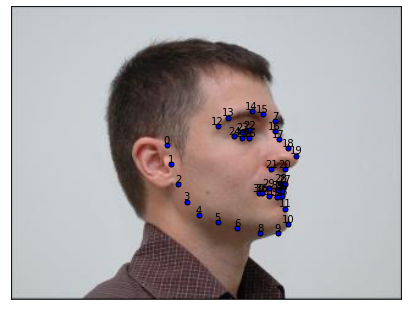

In [9]:
mask_index = np.array([1, 2, 3, 4, 5, 69, 70, 71, 72, 73, 74, 75, 18, 76, 77, 22,
                           28, 29, 30, 31, 34, 32, 39, 38, 37, 42, 41, 52, 51, 50, 49, 60, 59, 58, 63, 62, 61, 68, 67])-1

image.view()
image.landmarks['PTS']= mio.import_landmark_file(batch_image_names[0])

orig_pts = PointCloud((image.landmarks['PTS'].points[mask_index,0:2]))

orig_pts.view(marker_face_colour='b', render_numbering=True)

# frontal

In [10]:
image_path = './image/ID01_001.jpg'
image = mio.import_image(image_path)  
image_path = image.path
image_ID_name = image_path.stem
bounding_boxes, points = detect_face.detect_face(image.pixels_with_channels_at_back() * 255, minsize, pnet, rnet, onet, threshold, factor)
print('Box Number: %s' % bounding_boxes.shape[0])
batch_pixels = []
batch_trans = []
batch_image_names = []

for box_index in np.arange(bounding_boxes.shape[0]):
    bbox = PointCloud(bounding_boxes[box_index,[1,0,3,2]].reshape([2,2])).bounding_box()
    crop_img, crop_trans = crop_image_bounding_box(image, bbox, [256., 256.], base=256./256., order=1)
    input_pixels = crop_img.pixels_with_channels_at_back()
    batch_pixels.append(input_pixels)
    batch_trans.append(crop_trans)
    batch_image_names.append('./image/' + image_ID_name + '__' + str(box_index) + '.pts')
    
pts_pred = sess.run(
    pts_predictions,
    feed_dict={images_input: np.stack(batch_pixels, axis=0)})

for inner_batch_index in np.arange(bounding_boxes.shape[0]):
    orig_pts = batch_trans[inner_batch_index].apply(PointCloud(pts_pred[inner_batch_index]))
    template.landmarks['SAVEPTS'] = orig_pts
    mio.export_landmark_file(template.landmarks['SAVEPTS'], batch_image_names[inner_batch_index],extension='pts', overwrite=True)

Box Number: 1


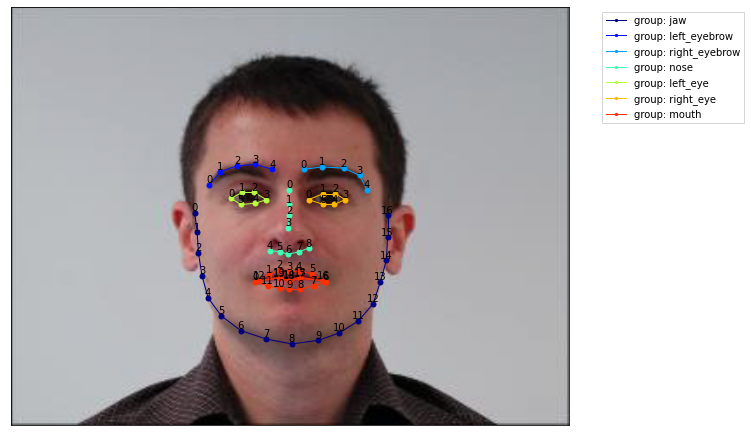

In [11]:
mask_index = np.arange(68)
image.view()
image.landmarks['PTS']= mio.import_landmark_file(batch_image_names[0])

template.landmarks['PTS'].points = image.landmarks['PTS'].points[mask_index,0:2]
lm = template.landmarks['PTS']
lm.view(marker_size=5,render_numbering=True)  